# Groupe E - Projet de Deep Learning 

Luis Dierick, Tom Marchal

## Mise en place

Pour réaliser ce projet, nous avons besoin de plusieurs librairies python. A savoir principalement : 
- PyTorch et Scikit Learn pour pouvoir créer notre CNN et utiliser des fonctions utiles en machine learning
- Numpy pour manipuler et calculer certaines caractéristiques sur des tableaux
- Matplotlib pour visualiser nos résultats

Pour information, le modèle a été entrainé sur un GPU Intel d'où la présence du module `intel_extension_for_pytorch` qui permet d'utiliser l'accelération GPU et optimiser les calculs sur celle-ci.
Cependant, le code est quand même également optimisé pour un gpu CUDA.

On definit également certaines variables qui resteront constantes durant l'entrainement.

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms.v2 as T2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler

import intel_extension_for_pytorch as ipex

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Utilise la carte graphique, si GPU cuda est disponible
device = 'xpu' if torch.xpu.is_available() else 'cpu' # Utilise la carte graphique, si GPU intel est disponible
print(device)


NB_CLASSES = 8
CLASSES = ['battery', 'cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textile']
NB_EPOCHS = 50
BATCH_SIZE = 64
DTYPE = torch.bfloat16
LR = 0.001
L1_REG = 0.01
TRAIN_DATA = "./waste-classification-challenge/train/train/"
TEST_DATA = "./waste-classification-challenge/test/test/"


xpu


## Données
Au niveau des données, nous avons reçu initialement $\approx$ 8000 images de déchets. Le set d'entrainement contient $\approx$ 5500 images labbelées en 8 catégories (battery, cardboard, glass, metal, organic, paper, plastic, textile). Les $\approx$ 2500 images restantes ne sont pas labbelées et servent à soumettre nos predictions pour la competition Kaggle.




In [3]:
train_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.RandomHorizontalFlip(),
        T2.RandomRotation(degrees=30),
        T2.RandomResizedCrop(224, scale=(0.6, 1), antialias=True),
        T2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)),
        T2.GaussianBlur(kernel_size=(3, 9)),
    ]
).to(device)

test_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.Resize(224, antialias=True),
        T2.CenterCrop(224),
    ]
).to(device)

dataset = ImageFolder(root=TRAIN_DATA)
    
    

Avant tout, observons la distribution des données en termes de categories afin de voir si certaines précoutions devrons être prises avant l'entrainement d'un modèle.

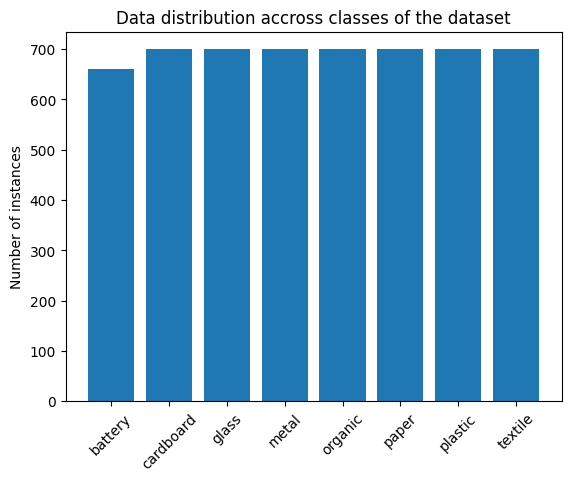

In [3]:
# Data distribution
x = np.arange(NB_CLASSES)
y = []
for i in range(NB_CLASSES):
    y.append(dataset.targets.count(i))

plt.title("Data distribution accross classes of the dataset")
plt.bar(x, y)
plt.xticks(x, CLASSES, rotation=45)
plt.ylabel("Number of instances")
plt.show()


### Préprocessing
Pour entrainer le modèle, on ne travaille pas directement sur l'image mais sur une représentation de celle sous forme d'une matrice (Tensor). Les variables `train_transform` et `test_transform` permettent de réaliser ces transformations en plus de les normaliser.

### Expension du dataset

Afin de d'améliorer au mieux la qualité de notre modèle, nous avons augmenter artificilement la taille du dataset. Grâce à la fonction transmorm de PyTorch nous pouvons facilement modifier nos images d'origines. Chaque image se vera appliquée les transformations suivantes :

1. Une probabilité de 0.5 d'avoir un retournement horizontal
2. Une rotation allant de -30 à 30 degrées
3. Une redimension aléatoire d'une taille allant jusqu'à 256x256 pixels
4. Des modifications de contraste, luminosité et de saturation
5. Et enfin, un flou Gaussien

Ces transormations sont appliquées uniquement aux images prévues à l'entrainement. Les images de validation par contre, sont utilisées sans modifications afin de se rendre compte du comportement en situation réelle du modèle.

### Travail sur des données en 16 bits
Par défaut avec PyTorch, l'encodage des tensors et les calculs durant les entrainements se font sur 32 bits (float 32). Cela permet d'avoir une bonne precision et d'éviter au maximum les arrondissements machine. Cependant, nous avons décidé de passer en 16 bits (bfloat 16). De cette manière, cela nous permet de pouvoir entrainer des modèles plus complexes avec des tailles de batchs plus importantes vu que la VRAM du GPU à notre disposition n'en dispose que de 8GB. En plus de cela, cela permet des calculs plus rapides et donc des temps d'entrainements moins longs.


## Campagne de selection d'un modèle

### Procédure globale

Le workflow est le suivant : on sépare les données d'entrainements en un set d'entrainement et un set de validation. Ce set de validation permet d'evaluer les performances de nos modèles afin de pouvoir trouver le plus approprié. Une fois le modèle bien définit, on le réentrainera une nouvelle fois mais sur l'intégralité des données cette fois ci.

Afin de trouver une architecture adaptée à notre objectif, nous nous sommes inspiré de modèles de classifcation d'images existant. Dans notre cas, on s'est inspiré de VGG11. En partant de sa structure de base, nous avons essayé de l'adapter au mieux afin d'obtenir les meilleures performances possibles.


### Modèle final
Notre modèle final est composé de la manière suivante : 13 couches de convolution et 3 couches de perceptron pour la classification. La structure suit celle conventionnelle des modèles VGG, c'est à dire 2 couches de convolutions avant de réaliser un max pooling. La taille de filtres (kernel) est classiquement de 3 pour ce type de modèles. Du padding à été rajouter avant chaque convolution ce qui nous permet de bien prendre un compte des potentielles informations en bord d'image. Enfin, il est à noter que le réseau est de plus en plus complexe plus on avance dans l'extraction des features. Par contre, c'est l'inverse quand on se trouve dans les couches fully-connected.


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Dropout(0.3)

        )
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimentions in one
        x = torch.flatten(x, 1)
        
        # Classifiy the image
        x = self.classifier(x)
        return x
    

Au niveau de la loss, on utilise l'entropie. L'adaptation des poids se fera classiquement via une descente de gradients.

Encore une fois ici, la libraire `ipex` permet d'optimiser les calculs réaliser au sein du GPU si le modèle est entrainé en 16 bits.

In [5]:
model = CustomCNN(num_classes=NB_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9) #weight_decay=0.01
model = model.to(device)
criterion = criterion.to(device)
if device == 'xpu':
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=DTYPE)

nweights = 0
for name,weights in model.named_parameters():
    if 'bias' not in name:
        nweights = nweights + weights.numel()

### Entrainement
Ci-dessous se trouve la fonction d'entrainement prenant un paramètre le modèle et un set de batchs correspondant à une époque. Elle calculera pour chaque instance, une sortie au modèle et va en fonction de la valeur de loss faire de la rétropropagation afin de recalculer les nouveaux poids du réseau de neurones.

Cette fonction va à la fin renvoyer le modèle avec les poids à jour et 2 listes contenant les valeurs d'accuracy et de loss pour l'époque venant d'avoir eu lieu.

In [6]:
def train_epoch(model, train_loader):
    ########## Training ##########
    model.train()

    train_n_corrects = 0
    train_n_total = 0
    train_losses = []

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        #with torch.autocast(device_type=device, dtype=torch.bfloat16):
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target)
        _, predicted = torch.max(output, 1)

        L1_term = torch.tensor(0., requires_grad=True)
        for name, weights in model.named_parameters():
            if 'bias' not in name:
                weights_sum = torch.sum(torch.abs(weights))
            L1_term = L1_term + weights_sum
        L1_term = L1_term / nweights
        loss = loss + L1_REG * L1_term


        train_n_corrects += (predicted == target).sum().item()
        train_n_total += target.numel()
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_epoch_acc = train_n_corrects / train_n_total
    train_epoch_loss = np.mean(train_losses).__float__()

    ########## Print results ##########
    print(f"Train accuracy: {train_epoch_acc}")
    print(f"Train loss: {train_epoch_loss}")
    print("--------------------")

    return model, train_epoch_acc, train_epoch_loss

Maintenant, la fonction de validation qui prend les mêmes paramètres que la fonction `train_epoch()` sauf que celle-ci prendra en plus 2 listes vides. La première servira à récupérer les valeurs à prédire pour chaque instance d'image. La seconde, gardera en mémoire les classes prédites par le modèle pour ces images.

In [7]:
def test_model(model, test_loader, val_values, val_predictions):
    ########## Testing ##########
    model.eval()
    test_n_corrects = 0
    test_n_total = 0
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            _, predicted = torch.max(output, 1)

            val_values.append(target)
            val_predictions.append(predicted)
            test_n_corrects += (predicted == target).sum().item()
            test_n_total += target.numel()
            test_losses.append(loss.item())

    test_epoch_acc = test_n_corrects / test_n_total
    test_epoch_loss = np.mean(test_losses).__float__()

    #### Print results ####
    print(f"Test accuracy: {test_n_corrects / test_n_total}")
    print(f"Test loss: {np.mean(test_losses)}")
    print("--------------------")

    return test_epoch_acc, test_epoch_loss, val_values, val_predictions

La fonction `train_model()` est utilisée pour entrainer le modèle avec les données du dataset. Comme paramètres, elle récupère le modèle que l'on veut entrainer ainsi qu'un booléen qui nous permet d'indiquer si on utilise tout notre dataset pour entrainer le modèle ou non.
Si on n'utilise pas tout le dataset, on va donc séparer les données en données d'entrainement et de test. On sépare exactement les données afin d'avoir 80% de données d'entrainement et 20% de données de test.
Par la suite, la fonction va appeler la fonction train_epoch pour chaque epoch d'entrainement.
De plus, si le paramètre full_dataset est défini à FALSE, des graphes vont êtres affichés à la fin de l'entrainement afin de visualiser les résultats.

In [8]:
def train_model(model, full_dataset):

    if full_dataset:
        dataset.transform = train_transform
        sampler = RandomSampler(dataset)
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    elif not full_dataset:
        train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
        train_dataset.dataset.transform = train_transform
        test_dataset.dataset.transform = test_transform
        train_sampler = RandomSampler(train_dataset)
        test_sampler = RandomSampler(test_dataset)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)


    train_graph_acc = []
    train_graph_loss = []
    test_graph_acc = []
    test_graph_loss = []

    val_values = []
    val_predictions = []
        

    for epoch in range(NB_EPOCHS):
        print(f"Epoch {epoch}")
        model, train_epoch_acc, train_epoch_loss = train_epoch(model, train_loader)

        if not full_dataset:
            val_values = []
            val_predictions = []

            test_epoch_acc, test_epoch_loss, val_values, val_predictions = test_model(model, test_loader, val_values, val_predictions)
            
            train_graph_acc.append(train_epoch_acc)
            train_graph_loss.append(train_epoch_loss)
            test_graph_acc.append(test_epoch_acc)
            test_graph_loss.append(test_epoch_loss)
    
    
    if not full_dataset:
        ########## Visualise results ##########
        x = np.arange(1, NB_EPOCHS + 1)
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Number of epochs')
        ax1.set_ylabel('Accuracy')
        ax1.plot(x, train_graph_acc, label='Train Accuracy', color='tab:blue')
        ax1.plot(x, test_graph_acc, label='Test Accuracy', color='tab:cyan')
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Loss')
        ax2.plot(x, train_graph_loss, label='Train Loss', color='tab:green')
        ax2.plot(x, test_graph_loss, label='Test Loss', color='tab:olive')
        ax2.tick_params(axis='y')
        fig.legend()
        plt.show()

        plt.figure()
        cm = confusion_matrix(torch.cat(val_values).cpu(), torch.cat(val_predictions).cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
        cm_display.plot(xticks_rotation='vertical')
        plt.show()
    
    return model

### Techniques de régularisation

En termes de régularisation nous avons d'abord utilisé du dataset augmentation. Cela de régulariser le modèle dans le sens où ça permet de le rendre insensible à certaines transformations d'images et donc généraliser encore plus le modèle.

Ensuite, la technique du dropout à été utilisée. Cette technique consiste à retirer un certain nombre de neurones dans le réseau durant l'entrainement. Cela permet de mieux répartir les poids entre les neurones et de pas finir avec un réseau trop dépendant de certaines connections. Il est également à noter que nous avons normalisé les résultats des calculs entre chaque couches de notre modèle, ce qui nous a permis de gagner encore quelques points de performance.

Enfin, de la régularisation L1 à été réalisée.


Ces techniques sont utilisées afin de limiter les chances d'avoir un overfitting sur les données d'entrainement.
### Résultats

Epoch 0


100%|██████████| 70/70 [00:21<00:00,  3.23it/s]


Train accuracy: 0.36285971223021585
Train loss: 1.948940168108259
--------------------


100%|██████████| 18/18 [00:02<00:00,  7.21it/s]


Test accuracy: 0.4739208633093525
Test loss: 1.8385416666666667
--------------------
Epoch 1


100%|██████████| 70/70 [00:20<00:00,  3.37it/s]


Train accuracy: 0.5325989208633094
Train loss: 1.786440168108259
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.32it/s]


Test accuracy: 0.5773381294964028
Test loss: 1.7400173611111112
--------------------
Epoch 2


100%|██████████| 70/70 [00:21<00:00,  3.32it/s]


Train accuracy: 0.5980215827338129
Train loss: 1.719252668108259
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.49it/s]


Test accuracy: 0.6205035971223022
Test loss: 1.6848958333333333
--------------------
Epoch 3


100%|██████████| 70/70 [00:20<00:00,  3.36it/s]


Train accuracy: 0.6575989208633094
Train loss: 1.6624446323939732
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.37it/s]


Test accuracy: 0.552158273381295
Test loss: 1.7339409722222223
--------------------
Epoch 4


100%|██████████| 70/70 [00:20<00:00,  3.43it/s]


Train accuracy: 0.6960431654676259
Train loss: 1.6230473109654018
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.82it/s]


Test accuracy: 0.5971223021582733
Test loss: 1.6883680555555556
--------------------
Epoch 5


100%|██████████| 70/70 [00:19<00:00,  3.59it/s]


Train accuracy: 0.72931654676259
Train loss: 1.5871099063328333
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.71it/s]


Test accuracy: 0.6699640287769785
Test loss: 1.6115451388888888
--------------------
Epoch 6


100%|██████████| 70/70 [00:19<00:00,  3.54it/s]


Train accuracy: 0.7587679856115108
Train loss: 1.5553019319261823
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


Test accuracy: 0.7212230215827338
Test loss: 1.5759548611111112
--------------------
Epoch 7


100%|██████████| 70/70 [00:19<00:00,  3.67it/s]


Train accuracy: 0.795863309352518
Train loss: 1.5165743350982666
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Test accuracy: 0.7050359712230215
Test loss: 1.5802951388888888
--------------------
Epoch 8


100%|██████████| 70/70 [00:19<00:00,  3.67it/s]


Train accuracy: 0.8235161870503597
Train loss: 1.4871100493839808
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.02it/s]


Test accuracy: 0.689748201438849
Test loss: 1.59765625
--------------------
Epoch 9


100%|██████████| 70/70 [00:19<00:00,  3.62it/s]


Train accuracy: 0.8424010791366906
Train loss: 1.4670207636696952
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.09it/s]


Test accuracy: 0.7724820143884892
Test loss: 1.5286458333333333
--------------------
Epoch 10


100%|██████████| 70/70 [00:18<00:00,  3.72it/s]


Train accuracy: 0.8610611510791367
Train loss: 1.4443646039281572
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.65it/s]


Test accuracy: 0.7769784172661871
Test loss: 1.5143229166666667
--------------------
Epoch 11


100%|██████████| 70/70 [00:19<00:00,  3.66it/s]


Train accuracy: 0.8788219424460432
Train loss: 1.4269539185932705
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


Test accuracy: 0.7796762589928058
Test loss: 1.5073784722222223
--------------------
Epoch 12


100%|██████████| 70/70 [00:19<00:00,  3.61it/s]


Train accuracy: 0.8938848920863309
Train loss: 1.4036281313214982
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.15it/s]


Test accuracy: 0.7311151079136691
Test loss: 1.5555555555555556
--------------------
Epoch 13


100%|██████████| 70/70 [00:19<00:00,  3.60it/s]


Train accuracy: 0.9114208633093526
Train loss: 1.39023528780256
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.15it/s]


Test accuracy: 0.789568345323741
Test loss: 1.5017361111111112
--------------------
Epoch 14


100%|██████████| 70/70 [00:18<00:00,  3.70it/s]


Train accuracy: 0.9242356115107914
Train loss: 1.3737174306597029
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.89it/s]


Test accuracy: 0.8120503597122302
Test loss: 1.4782986111111112
--------------------
Epoch 15


100%|██████████| 70/70 [00:19<00:00,  3.60it/s]


Train accuracy: 0.9336780575539568
Train loss: 1.361440644945417
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


Test accuracy: 0.8192446043165468
Test loss: 1.4700520833333333
--------------------
Epoch 16


100%|██████████| 70/70 [00:18<00:00,  3.74it/s]


Train accuracy: 0.9399730215827338
Train loss: 1.3565299902643477
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


Test accuracy: 0.8174460431654677
Test loss: 1.4652777777777777
--------------------
Epoch 17


100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


Train accuracy: 0.9449190647482014
Train loss: 1.3494987998689925
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


Test accuracy: 0.8174460431654677
Test loss: 1.4691840277777777
--------------------
Epoch 18


100%|██████████| 70/70 [00:18<00:00,  3.74it/s]


Train accuracy: 0.9536870503597122
Train loss: 1.3409050498689925
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.75it/s]


Test accuracy: 0.8300359712230215
Test loss: 1.4539930555555556
--------------------
Epoch 19


100%|██████████| 70/70 [00:19<00:00,  3.64it/s]


Train accuracy: 0.9669514388489209
Train loss: 1.3247220141547067
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.17it/s]


Test accuracy: 0.8057553956834532
Test loss: 1.48046875
--------------------
Epoch 20


100%|██████████| 70/70 [00:18<00:00,  3.76it/s]


Train accuracy: 0.9676258992805755
Train loss: 1.3217086212975637
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.18it/s]


Test accuracy: 0.8597122302158273
Test loss: 1.4327256944444444
--------------------
Epoch 21


100%|██████████| 70/70 [00:19<00:00,  3.61it/s]


Train accuracy: 0.9736960431654677
Train loss: 1.3127800498689923
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.06it/s]


Test accuracy: 0.8093525179856115
Test loss: 1.4735243055555556
--------------------
Epoch 22


100%|██████████| 70/70 [00:18<00:00,  3.76it/s]


Train accuracy: 0.9777428057553957
Train loss: 1.3092086212975638
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.12it/s]


Test accuracy: 0.8444244604316546
Test loss: 1.4388020833333333
--------------------
Epoch 23


100%|██████████| 70/70 [00:18<00:00,  3.76it/s]


Train accuracy: 0.9766187050359713
Train loss: 1.307757728440421
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.93it/s]


Test accuracy: 0.8156474820143885
Test loss: 1.4626736111111112
--------------------
Epoch 24


100%|██████████| 70/70 [00:19<00:00,  3.62it/s]


Train accuracy: 0.9788669064748201
Train loss: 1.3065300498689925
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.10it/s]


Test accuracy: 0.8336330935251799
Test loss: 1.4422743055555556
--------------------
Epoch 25


100%|██████████| 70/70 [00:18<00:00,  3.75it/s]


Train accuracy: 0.9849370503597122
Train loss: 1.2996104070118495
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.98it/s]


Test accuracy: 0.8552158273381295
Test loss: 1.4309895833333333
--------------------
Epoch 26


100%|██████████| 70/70 [00:18<00:00,  3.70it/s]


Train accuracy: 0.9860611510791367
Train loss: 1.297601478440421
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.09it/s]


Test accuracy: 0.8570143884892086
Test loss: 1.4301215277777777
--------------------
Epoch 27


100%|██████████| 70/70 [00:18<00:00,  3.79it/s]


Train accuracy: 0.9869604316546763
Train loss: 1.296038978440421
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.05it/s]


Test accuracy: 0.8201438848920863
Test loss: 1.4622395833333333
--------------------
Epoch 28


100%|██████████| 70/70 [00:19<00:00,  3.56it/s]


Train accuracy: 0.9889838129496403
Train loss: 1.2939184427261352
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.00it/s]


Test accuracy: 0.8480215827338129
Test loss: 1.4427083333333333
--------------------
Epoch 29


100%|██████████| 70/70 [00:18<00:00,  3.76it/s]


Train accuracy: 0.9921312949640287
Train loss: 1.2909050498689925
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.02it/s]


Test accuracy: 0.8480215827338129
Test loss: 1.4353298611111112
--------------------
Epoch 30


100%|██████████| 70/70 [00:18<00:00,  3.74it/s]


Train accuracy: 0.9928057553956835
Train loss: 1.2890077284404209
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


Test accuracy: 0.8561151079136691
Test loss: 1.4279513888888888
--------------------
Epoch 31


100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


Train accuracy: 0.9930305755395683
Train loss: 1.2892309427261353
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.99it/s]


Test accuracy: 0.8525179856115108
Test loss: 1.4279513888888888
--------------------
Epoch 32


100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


Train accuracy: 0.9943794964028777
Train loss: 1.2876684427261353
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


Test accuracy: 0.8444244604316546
Test loss: 1.4361979166666667
--------------------
Epoch 33


100%|██████████| 70/70 [00:19<00:00,  3.57it/s]


Train accuracy: 0.9941546762589928
Train loss: 1.287556835583278
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.99it/s]


Test accuracy: 0.8318345323741008
Test loss: 1.4396701388888888
--------------------
Epoch 34


100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


Train accuracy: 0.9957284172661871
Train loss: 1.2856595141547067
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


Test accuracy: 0.8597122302158273
Test loss: 1.4197048611111112
--------------------
Epoch 35


100%|██████████| 70/70 [00:19<00:00,  3.51it/s]


Train accuracy: 0.9957284172661871
Train loss: 1.285882728440421
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.71it/s]


Test accuracy: 0.8534172661870504
Test loss: 1.4223090277777777
--------------------
Epoch 36


100%|██████████| 70/70 [00:18<00:00,  3.70it/s]


Train accuracy: 0.9959532374100719
Train loss: 1.285882728440421
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


Test accuracy: 0.8489208633093526
Test loss: 1.4292534722222223
--------------------
Epoch 37


100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


Train accuracy: 0.9968525179856115
Train loss: 1.2851014784404209
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.84it/s]


Test accuracy: 0.8552158273381295
Test loss: 1.4301215277777777
--------------------
Epoch 38


100%|██████████| 70/70 [00:19<00:00,  3.54it/s]


Train accuracy: 0.9946043165467626
Train loss: 1.288673026221139
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.75it/s]


Test accuracy: 0.8453237410071942
Test loss: 1.4375
--------------------
Epoch 39


100%|██████████| 70/70 [00:18<00:00,  3.71it/s]


Train accuracy: 0.9959532374100719
Train loss: 1.2862177882875716
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.19it/s]


Test accuracy: 0.8282374100719424
Test loss: 1.4487847222222223
--------------------
Epoch 40


100%|██████████| 70/70 [00:18<00:00,  3.79it/s]


Train accuracy: 0.9966276978417267
Train loss: 1.2845436811447144
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


Test accuracy: 0.8498201438848921
Test loss: 1.4283854166666667
--------------------
Epoch 41


100%|██████████| 70/70 [00:19<00:00,  3.61it/s]


Train accuracy: 0.9966276978417267
Train loss: 1.2848785025732858
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.12it/s]


Test accuracy: 0.8633093525179856
Test loss: 1.4205729166666667
--------------------
Epoch 42


100%|██████████| 70/70 [00:18<00:00,  3.77it/s]


Train accuracy: 0.9970773381294964
Train loss: 1.284432074001857
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


Test accuracy: 0.8669064748201439
Test loss: 1.4144965277777777
--------------------
Epoch 43


100%|██████████| 70/70 [00:19<00:00,  3.67it/s]


Train accuracy: 0.997751798561151
Train loss: 1.283539216859
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


Test accuracy: 0.8633093525179856
Test loss: 1.4136284722222223
--------------------
Epoch 44


100%|██████████| 70/70 [00:18<00:00,  3.68it/s]


Train accuracy: 0.9982014388489209
Train loss: 1.2833160025732857
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.18it/s]


Test accuracy: 0.8651079136690647
Test loss: 1.4214409722222223
--------------------
Epoch 45


100%|██████████| 70/70 [00:18<00:00,  3.76it/s]


Train accuracy: 0.997976618705036
Train loss: 1.2830927882875716
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


Test accuracy: 0.8606115107913669
Test loss: 1.4227430555555556
--------------------
Epoch 46


100%|██████████| 70/70 [00:18<00:00,  3.71it/s]


Train accuracy: 0.997976618705036
Train loss: 1.283427609716143
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.10it/s]


Test accuracy: 0.8678057553956835
Test loss: 1.4162326388888888
--------------------
Epoch 47


100%|██████████| 70/70 [00:19<00:00,  3.66it/s]


Train accuracy: 0.997976618705036
Train loss: 1.2833160025732857
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.84it/s]


Test accuracy: 0.8507194244604317
Test loss: 1.4275173611111112
--------------------
Epoch 48


100%|██████████| 70/70 [00:19<00:00,  3.56it/s]


Train accuracy: 0.997751798561151
Train loss: 1.2833160025732857
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.82it/s]


Test accuracy: 0.8642086330935251
Test loss: 1.4140625
--------------------
Epoch 49


100%|██████████| 70/70 [00:19<00:00,  3.66it/s]


Train accuracy: 0.997751798561151
Train loss: 1.283427609716143
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


Test accuracy: 0.8633093525179856
Test loss: 1.4131944444444444
--------------------


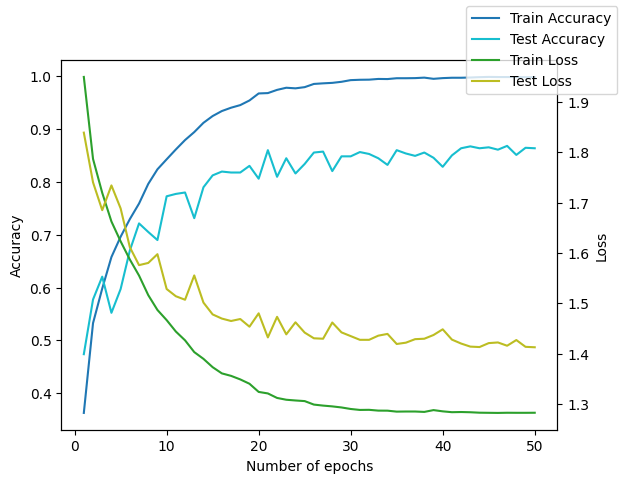

<Figure size 640x480 with 0 Axes>

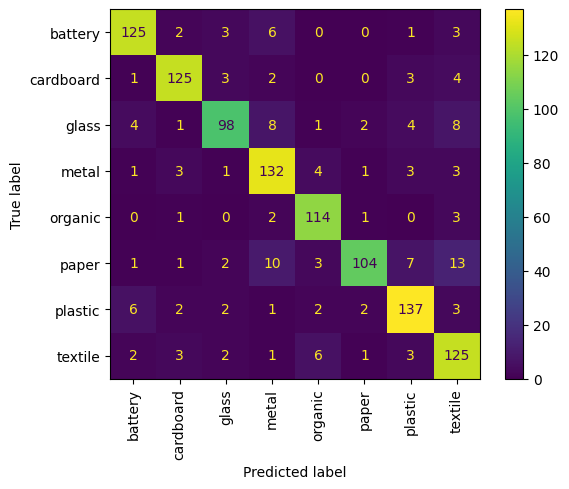

In [9]:
trained_model = train_model(model, full_dataset=False)

########## Save the model ##########
torch.save(trained_model.state_dict(), 'model.pth')


## Problèmes rencontrés
Durant le projet nous avons été confrontés à un problème. Quand nous essayons d'entrainer le modèle sur l'intégralité de nos données d'entrainement nous rencontrons une erreur lié à une fonction de la libraire de PyTorch. Pourant, aucun problème quand nos données sont divisées. Donc nous pensons que cela doit être lié à une erreur dans notre code mais impossible de trouver la source. Après quelques recherches internet, il se peut également que cela soit un problème interne à la librairie qui doit être fixé.

## Submission Kaggle
Cette partie est consacrée à reprendre le modèle entrainé et à prédire une classe sur de nouvelles images non connues et non labellées. Ces prédictions sont exportées dans un fichier .csv avec les identifiants de chaque image afin de pouvoir être évaluées dans le cadre d'une compétiton Kaggle.


In [10]:
class WasteSubmissionDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.image_list = os.listdir(main_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.image_list[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        img_id = os.path.splitext(os.path.basename(img_loc))[0]
        return tensor_image, img_id

test_dataset = WasteSubmissionDataset(main_dir=TEST_DATA, transform=test_transform)
submission_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



Ici, on redéfinit une classe personnalisée pour transformer nos images en Tensors. Les transformations appliquées sont identiques à celles du set de validation.

In [11]:
def generate_submission(model, submission_loader):
    model.eval()

    images_id = []
    predictions = []
    
    with torch.no_grad():
        for batch_idx, (img, tuple_img_id) in enumerate(submission_loader):
            img = img.to(device)
            output = model(img)
            prob = torch.nn.functional.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            for i, img_id  in enumerate(tuple_img_id):
                images_id.append(img_id)
                predictions.append(CLASSES[predicted[i]])
    
    
    df = pd.DataFrame({'ID': images_id, 'Label': predictions})
    df.to_csv('submission.csv', index=False)
    
    print(df.head())

generate_submission(trained_model, submission_loader)

                                     ID    Label
0  69d436c1-429f-4c15-b780-bf599f779ae2  battery
1  02b8a2d3-7444-4e50-9f46-d1fbc7f1c5a4  organic
2  aff9561d-77cc-4d15-a77f-9b3477acb968    paper
3  772a7ee5-97c0-4b4f-82c1-4e36486fb488  battery
4  69e14833-a7be-45e7-8c35-7504245e72ab  textile
